In [ ]:
def generate_colab_link(username, repo, branch, notebook_path):
    # Substitui espaços por %20
    notebook_path_encoded = notebook_path.replace(" ", "%20")
    return f"https://colab.research.google.com/github/{username}/{repo}/blob/{branch}/{notebook_path_encoded}"

# Exemplo de uso
username = "gutosantos-github"
repo = "amsaude"
branch = "master"
notebook_path = "/5-projeto_aplicacao/projeto_app_novo.ipynb"

link = generate_colab_link(username, repo, branch, notebook_path)
print(f"<a href='{link}' target='_blank'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Abrir no Google Colab'/></a>")

<a href='https://colab.research.google.com/github/gutosantos-github/amsaude/blob/master//5-projeto_aplicacao/projeto_app_novo.ipynb' target='_blank'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Abrir no Google Colab'/></a>


<a href='https://colab.research.google.com/github/gutosantos-github/amsaude/blob/master//5-projeto_aplicacao/projeto_app_novo.ipynb' target='_blank'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Abrir no Google Colab'/></a>


# Projeto de Aplicação - Malicious Traffic Detection in IoT
Healthcare Environment
- Programa de Pós-Graduação em Computação
- Aprendizado de Máquina na Saúde
- Prof. Flávio Luiz Seixas

- Nome: Augusto Cesar da F. dos Santos
- Matrícula: M048.124.004
- Fonte: https://www.kaggle.com/datasets/faisalmalik/iot-healthcare-security-dataset


# Projeto de Aplicação baseado no artigo A Framework for Malicious Traffic Detection in IoT Healthcare Environment

## O framework IoT-Flock
- O framework IoT-Flock proposto consiste em uma ferramenta recém-criada e de
código aberto para geração de dados IoT chamada IoT-Flock;
- A ferramenta permite que os pesquisadores desenvolvam casos de uso
compostos tanto por dispositivos normais quanto maliciosos e gerem
tráfego inerentes; e
- O objetivo foi aplicar diferentes técnicas de aprendizado de máquina (AM)
no intuito de obter uma classificação binário no que tange a detectar ciberataques em um conjunto de dados a fim de proteger o sistema de saúde em
uma Unidade de Terapia Intensivo (UTI).

## Cenário de Caso de Uso
-  A infraestrutura do testbed foi dividida em duas redes para desenvolver um
conjunto de dados extenso, ou seja, uma rede segura ['patientMonitoring.csv', 'environmentMonitoring.csv'] e uma rede atacante ['Attack.csv'];
  -  Na rede segura está o broker MQTT implantado, além de vários
dispositivos com o mesmo protocolo transmitindo e recebendo os dados;
  - Na rede atacante existem entidades maliciosas (clientes ou subscribers)
originando diferentes tipos de ataques para outros clientes e para o
broker;
    - A rede invasora inclui dez dispositivos atacantes que estão gerando quatro
tipos de ataques, incluindo:
      -  MQTT distributed denial-of-service,
      - MQTT publish flood,
      - brute force, and
      - SlowITE attack

# MQTT DDoS (Distributed Denial of Service)

Um ataque de MQTT Distributed Denial of Service (DDoS) exploraria principalmente os seguintes atributos:


- mqtt.hdrflags: Sinais específicos no cabeçalho podem ajudar a identificar ataques, como tentativas de sobrecarregar o sistema.
- mqtt.kalive: Um valor de keep-alive inadequado pode ser manipulado para manter conexões ativas por longos períodos, sobrecarregando o servidor.
- mqtt.len: Tamanhos de mensagem anormais podem indicar tráfego excessivo.
- mqtt.msgtype: Tipos específicos de mensagens, como PUBLISH, podem ser usados repetidamente para saturar o sistema.
- algumas flags TCP

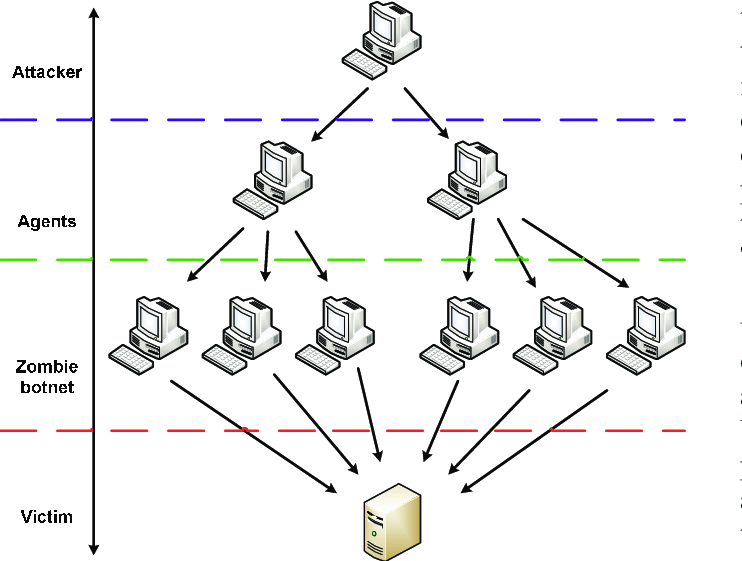

# Atributos importantes para análise

frame.time_relative: O tempo relativo desde o início da captura, útil para analisar intervalos de pacotes.

tcp.time_delta: Diferença de tempo entre pacotes TCP, indicando atrasos na transmissão.

tcp.flags.push: Mostra se a flag de push do TCP está ativada, indicando transferência imediata de dados.

tcp.hdr_len: Comprimento do cabeçalho TCP, relevante para identificar a estrutura do pacote.

tcp.pdu.size: Tamanho da Unidade de Dados de Protocolo (PDU) em TCP, medindo o tamanho da carga útil.


mqtt.hdrflags: Flags de cabeçalho em pacotes MQTT, úteis para o controle do protocolo.

mqtt.kalive: Tempo de keep-alive do MQTT, que ajuda na gestão de sessões.

mqtt.len: Comprimento do payload da mensagem MQTT.

mqtt.msgtype: Tipo de mensagem MQTT (e.g., CONNECT, PUBLISH).

mqtt.topic_len: Comprimento do tópico MQTT, relacionado ao destino da mensagem.

mqtt.ver: Versão do MQTT utilizada.

tcp.flags.ack: Status da flag de reconhecimento TCP.

tcp.flags.syn: Flag de sincronização TCP, inicia uma conexão.

rótulo: Indica se o tráfego é malicioso ou benigno.

In [54]:
import pandas as pd
import numpy as np

import missingno as missno
import io, os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
#plt.figure(figsize=(largura, altura))
plt.rcParams["figure.figsize"] = (8, 6)

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif

from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict, KFold,cross_val_score

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

#Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from google.colab import drive


In [4]:
#Montando o drive para carregar o arquivo
GOOGLE_COLAB = "google.colab" in str(get_ipython())

if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [163]:
drive = '/content/drive/MyDrive/2024-2/4 - AM_na_saude/projeto_app/ICUDatasetProcessed/'

In [164]:
csvs = os.listdir(drive)
csvs

['Attack.csv', 'patientMonitoring.csv', 'environmentMonitoring.csv']

In [165]:
total_rows=0
for csv in csvs:
    data = pd.read_csv(drive + csv)
    total_rows+=len(data)
    print(f'O arquivo {csv} tem {data.shape[0]} linhas e {data.shape[1]} colunas.')
    print(f'Total esperado de linhas: {total_rows}')

O arquivo Attack.csv tem 80126 linhas e 52 colunas.
Total esperado de linhas: 80126
O arquivo patientMonitoring.csv tem 76810 linhas e 52 colunas.
Total esperado de linhas: 156936
O arquivo environmentMonitoring.csv tem 31758 linhas e 52 colunas.
Total esperado de linhas: 188694


In [166]:
df1 = pd.read_csv(os.path.join(drive, 'environmentMonitoring.csv'))
df2 = pd.read_csv(os.path.join(drive, 'Attack.csv'))
df3 = pd.read_csv(os.path.join(drive, 'patientMonitoring.csv'))

In [167]:
# Extrair nomes das colunas de cada DataFrame
colunas_df1 = set(df1.columns)
colunas_df2 = set(df2.columns)
colunas_df3 = set(df3.columns)

# Verificar se os nomes das colunas são os mesmos
if colunas_df1 == colunas_df2 == colunas_df3:
    print("Todos os arquivos têm os mesmos nomes de colunas.")
else:
    print("Os arquivos têm nomes de colunas diferentes.")

    # Mostrar diferenças
    print("Colunas em arquivo1 e não em arquivo2:", colunas_df1 - colunas_df2)
    print("Colunas em arquivo2 e não em arquivo3:", colunas_df2 - colunas_df3)
    print("Colunas em arquivo3 e não em arquivo1:", colunas_df3 - colunas_df1)

Todos os arquivos têm os mesmos nomes de colunas.


In [141]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31758 entries, 0 to 31757
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   frame.time_delta       31758 non-null  float64
 1   frame.time_relative    31758 non-null  float64
 2   frame.len              31758 non-null  int64  
 3   ip.src                 31758 non-null  object 
 4   ip.dst                 31758 non-null  object 
 5   tcp.srcport            31758 non-null  int64  
 6   tcp.dstport            31758 non-null  int64  
 7   tcp.flags              31758 non-null  object 
 8   tcp.time_delta         31758 non-null  float64
 9   tcp.len                31758 non-null  int64  
 10  tcp.ack                31758 non-null  int64  
 11  tcp.connection.fin     31758 non-null  float64
 12  tcp.connection.rst     31758 non-null  float64
 13  tcp.connection.sack    31758 non-null  float64
 14  tcp.connection.syn     31758 non-null  float64
 15  tc

In [11]:
df1.sample(5)

,frame.time_delta,frame.time_relative,frame.len,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_delta,tcp.len,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
7369,0.000079,678.819139,72,10.5.126.84,10.5.126.157,1883,37755,0x00000018,0.000079,4,...,0.0,0.0,0,0.0,0.0,0.0,6,64,environmentMonitoring,0
20313,0.000016,1875.820322,72,10.5.126.84,10.5.126.136,1883,34429,0x00000018,0.000016,4,...,0.0,0.0,0,0.0,0.0,0.0,6,64,environmentMonitoring,0
28960,3.002294,1519.250153,79,10.5.150.157,10.5.150.109,44853,1883,0x00000018,3.002755,11,...,1.0,0.0,Fire,4.0,0.0,0.0,6,64,environmentMonitoring,0
25122,2.996264,790.246660,82,10.5.150.153,10.5.150.109,40787,1883,0x00000018,4.999478,14,...,0.0,0.0,Humidity,8.0,0.0,0.0,6,64,environmentMonitoring,0
27090,0.000011,1162.246727,72,10.5.150.109,10.5.150.156,1883,37361,0x00000018,0.000117,4,...,0.0,0.0,0,0.0,0.0,0.0,6,64,environmentMonitoring,0


In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
frame.time_delta,31758.0,0.125325,0.538998,0.0,0.000017,0.000031,0.000061,3.148110
frame.time_relative,31758.0,985.308424,571.907904,0.0,489.819950,984.819487,1479.827982,2047.246210
frame.len,31758.0,78.299515,5.168694,70.0,72.000000,80.000000,83.000000,105.000000
tcp.srcport,31758.0,28729.786322,17608.643713,1883.0,1883.000000,37361.000000,41065.000000,46547.000000
tcp.dstport,31758.0,12681.558096,16895.495691,1883.0,1883.000000,1883.000000,34429.000000,46547.000000
tcp.time_delta,31758.0,2.605088,1.967203,0.0,0.000217,2.999633,4.996213,5.029132
tcp.len,31758.0,10.299515,5.168694,2.0,4.000000,12.000000,15.000000,37.000000
tcp.ack,31758.0,1483.713710,2023.731246,1.0,39.500000,409.000000,2247.000000,8302.000000
tcp.connection.fin,31758.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
tcp.connection.rst,31758.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80126 entries, 0 to 80125
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   frame.time_delta       80126 non-null  float64
 1   frame.time_relative    80126 non-null  float64
 2   frame.len              80126 non-null  int64  
 3   ip.src                 80126 non-null  object 
 4   ip.dst                 80126 non-null  object 
 5   tcp.srcport            80126 non-null  int64  
 6   tcp.dstport            80126 non-null  int64  
 7   tcp.flags              80126 non-null  object 
 8   tcp.time_delta         80126 non-null  float64
 9   tcp.len                80126 non-null  int64  
 10  tcp.ack                80126 non-null  int64  
 11  tcp.connection.fin     80126 non-null  float64
 12  tcp.connection.rst     80126 non-null  float64
 13  tcp.connection.sack    80126 non-null  float64
 14  tcp.connection.syn     80126 non-null  float64
 15  tc

In [ ]:
df2.sample(5)

,frame.time_delta,frame.time_relative,frame.len,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_delta,tcp.len,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
25359,0.000730,9.352736,1514,192.168.1.90,192.168.1.91,54557,1883,0x00000010,0.003240,1460,...,1.0,0.0,mqtt-malaria/beem.loadr-MBP-di-Ivan-5.lan-5476...,65.0,0.0,0.0,6,64,Attack,1
9829,0.000022,2.770112,233,192.168.1.90,192.168.1.91,54546,1883,0x00000018,0.000022,179,...,1.0,0.0,mqtt-malaria/beem.loadr-MBP-di-Ivan-5.lan-5476...,64.0,0.0,0.0,6,64,Attack,1
26569,0.000001,9.839023,78,192.168.1.91,192.168.1.90,1883,54557,0x00000018,0.000001,24,...,0.0,0.0,0,0.0,0.0,0.0,6,128,Attack,1
16156,0.000230,6.067463,62,192.168.1.91,192.168.1.90,1883,54562,0x00000018,0.001135,8,...,0.0,0.0,0,0.0,0.0,0.0,6,128,Attack,1
1504,0.000023,0.150477,74,10.16.120.72,10.16.120.44,1883,57296,0x00000012,0.000023,0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,64,Attack,1


In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
frame.time_delta,80126.0,0.005483,0.216919,0.0,0.000001,0.000015,0.000098,4.443631e+01
frame.time_relative,80126.0,45.000738,67.828988,0.0,7.257224,25.400610,53.717329,3.745976e+02
frame.len,80126.0,281.172129,481.186649,54.0,60.000000,66.000000,144.000000,1.514000e+03
tcp.srcport,80126.0,35633.730337,25332.316629,1883.0,1883.000000,54545.000000,54563.000000,6.547100e+04
tcp.dstport,80126.0,20841.751803,25344.442269,1883.0,1883.000000,1883.000000,54546.000000,6.547100e+04
tcp.time_delta,80126.0,0.015455,0.251808,0.0,0.000001,0.000030,0.000249,1.127602e+01
tcp.len,80126.0,224.751641,482.274661,0.0,0.000000,8.000000,90.000000,1.460000e+03
tcp.ack,80126.0,155836.923346,326772.612160,0.0,701.000000,12637.000000,35972.000000,1.712906e+06
tcp.connection.fin,80126.0,0.020605,0.142059,0.0,0.000000,0.000000,0.000000,1.000000e+00
tcp.connection.rst,80126.0,0.020380,0.141299,0.0,0.000000,0.000000,0.000000,1.000000e+00


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76810 entries, 0 to 76809
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   frame.time_delta       76810 non-null  float64
 1   frame.time_relative    76810 non-null  float64
 2   frame.len              76810 non-null  int64  
 3   ip.src                 76810 non-null  object 
 4   ip.dst                 76810 non-null  object 
 5   tcp.srcport            76810 non-null  int64  
 6   tcp.dstport            76810 non-null  int64  
 7   tcp.flags              76810 non-null  object 
 8   tcp.time_delta         76810 non-null  float64
 9   tcp.len                76810 non-null  int64  
 10  tcp.ack                76810 non-null  int64  
 11  tcp.connection.fin     76810 non-null  float64
 12  tcp.connection.rst     76810 non-null  float64
 13  tcp.connection.sack    76810 non-null  float64
 14  tcp.connection.syn     76810 non-null  float64
 15  tc

In [ ]:
df3.sample(5)

,frame.time_delta,frame.time_relative,frame.len,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_delta,tcp.len,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
44904,0.000036,3081.028284,86,10.5.126.148,10.5.126.56,33571,1883,0x00000018,1.987342,18,...,0.0,0.0,Pulsoximeter,12.0,0.0,0.0,6,64,patientMonitoring,0
44232,0.000034,3005.028728,86,10.5.126.148,10.5.126.56,33571,1883,0x00000018,2.000830,18,...,0.0,0.0,Pulsoximeter,12.0,0.0,0.0,6,64,patientMonitoring,0
46612,0.000046,3271.033420,78,10.5.126.145,10.5.126.56,46263,1883,0x00000018,2.002123,10,...,0.0,0.0,ECG,3.0,0.0,0.0,6,64,patientMonitoring,0
20133,0.000065,363.028823,78,10.5.126.165,10.5.126.56,44993,1883,0x00000018,1.999505,10,...,0.0,0.0,ECG,3.0,0.0,0.0,6,64,patientMonitoring,0
19677,0.000049,313.029524,86,10.5.126.148,10.5.126.56,37701,1883,0x00000018,1.999844,18,...,0.0,0.0,Pulsoximeter,12.0,0.0,0.0,6,64,patientMonitoring,0


In [ ]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
frame.time_delta,76810.0,0.133703,0.464622,0.0,0.000035,0.000087,0.000180,2.155548
frame.time_relative,76810.0,2921.691253,1891.546099,0.0,1314.960131,2712.962844,4479.037043,6611.038212
frame.len,76810.0,79.308449,14.766326,70.0,77.000000,78.000000,80.000000,1766.000000
tcp.srcport,76810.0,37652.780029,9866.519362,1883.0,35965.000000,38937.000000,42449.000000,46801.000000
tcp.dstport,76810.0,4098.876500,8897.447631,1883.0,1883.000000,1883.000000,1883.000000,46801.000000
tcp.time_delta,76810.0,3.501738,9.752309,0.0,1.995325,1.999715,2.002226,60.037328
tcp.len,76810.0,11.308449,14.766326,2.0,9.000000,10.000000,12.000000,1698.000000
tcp.ack,76810.0,637.383244,3793.878933,1.0,51.000000,99.000000,165.000000,59658.000000
tcp.connection.fin,76810.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
tcp.connection.rst,76810.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


# Etapa de Concatenação

In [168]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df.shape

(188694, 52)

# Início de Pré-processamento

In [169]:
print(df.duplicated().sum())

2


In [170]:
df = df.drop_duplicates()

In [171]:
print(df.duplicated().sum())

0


In [ ]:
# Lista para armazenar nomes das colunas que estão completamente vazias
empty_cols=[]

# Itera sobre cada coluna do dataframe
for col in df.columns:
  if df[col].isnull().all():
    empty_cols.append(col)
    if len(empty_cols == []):
      df.fillna(0, inplace=True)

print(f'Colunas vazias: {empty_cols}')

Colunas vazias: []


In [16]:
nan_count = df.isna().any(axis=1).sum()
print(f"Número de linhas com pelo menos um NaN: {nan_count}")

Número de linhas com pelo menos um NaN: 0


In [172]:
# Contar o número de NaN por coluna
nan_count_per_column = df.isna().sum()
print("Número de NaN por coluna:")
print(nan_count_per_column)

Número de NaN por coluna:
frame.time_delta         0
frame.time_relative      0
frame.len                0
ip.src                   0
ip.dst                   0
tcp.srcport              0
tcp.dstport              0
tcp.flags                0
tcp.time_delta           0
tcp.len                  0
tcp.ack                  0
tcp.connection.fin       0
tcp.connection.rst       0
tcp.connection.sack      0
tcp.connection.syn       0
tcp.flags.ack            0
tcp.flags.fin            0
tcp.flags.push           0
tcp.flags.reset          0
tcp.flags.syn            0
tcp.flags.urg            0
tcp.hdr_len              0
tcp.payload              0
tcp.pdu.size             0
tcp.window_size_value    0
tcp.checksum             0
mqtt.clientid            0
mqtt.clientid_len        0
mqtt.conack.flags        0
mqtt.conack.val          0
mqtt.conflag.passwd      0
mqtt.conflag.qos         0
mqtt.conflag.reserved    0
mqtt.conflag.retain      0
mqtt.conflag.willflag    0
mqtt.conflags            0
mq

In [173]:
df = df.dropna(axis=0, how='any')

In [174]:
df = df.loc[:, df.nunique() > 1]

In [175]:
df.columns

Index(['frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.src',
       'ip.dst', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_delta',
       'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack',
       'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn',
       'tcp.hdr_len', 'tcp.payload', 'tcp.pdu.size', 'tcp.window_size_value',
       'tcp.checksum', 'mqtt.clientid', 'mqtt.clientid_len',
       'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.dupflag', 'mqtt.hdrflags',
       'mqtt.kalive', 'mqtt.len', 'mqtt.msg', 'mqtt.msgtype', 'mqtt.qos',
       'mqtt.retain', 'mqtt.topic', 'mqtt.topic_len', 'mqtt.ver', 'ip.ttl',
       'class', 'label'],
      dtype='object')

In [176]:
len(df.columns)

43

In [22]:
def unique_vals(df, columns):
  for col_name in columns:
    print(f"Colunas: {col_name}\n{'-'*30}")
    unique_vals = df[col_name].unique()
    len_unique_vals = len(unique_vals)
    value_counts = df[col_name].value_counts()

    print(f'Valores Unicos: {len_unique_vals}\n')
    print(f"Value Counts: {value_counts}\n{'='*40}\n")

columns = df.columns.to_list()
unique_vals(df, columns)

Colunas: frame.time_delta
------------------------------
Valores Unicos: 11904

Value Counts: frame.time_delta
0.000001    14271
0.000000    12088
0.000003     2735
0.000025     2599
0.000024     2567
            ...  
6.886630        1
0.052399        1
0.051140        1
0.043011        1
0.004245        1
Name: count, Length: 11904, dtype: int64

Colunas: frame.time_relative
------------------------------
Valores Unicos: 176587

Value Counts: frame.time_relative
0.000000       8
36.572407      6
31.547406      6
40.406267      6
11.132515      6
              ..
21.247532      1
21.247564      1
21.265037      1
21.265987      1
6611.038212    1
Name: count, Length: 176587, dtype: int64

Colunas: frame.len
------------------------------
Valores Unicos: 633

Value Counts: frame.len
80      24622
54      18851
78      18603
86      17470
77      16885
        ...  
1226        1
1234        1
1108        1
1407        1
1120        1
Name: count, Length: 633, dtype: int64

Colunas: ip.

In [23]:
categ_feat = df.select_dtypes(include=['object']).columns
unique_vals(df, categ_feat)

Colunas: ip.src
------------------------------
Valores Unicos: 44

Value Counts: ip.src
192.168.1.90    46208
192.168.1.91    24714
10.5.126.147    10596
10.5.126.145    10596
10.5.126.148    10518
10.5.126.146    10518
10.5.126.167     6858
10.5.126.165     6858
10.5.126.168     6782
10.5.126.166     6780
10.5.126.84      6084
10.16.120.44     5114
10.5.126.56      4544
10.16.120.72     4088
10.5.150.109     3222
10.5.150.157     1436
10.5.150.152     1436
10.5.150.156     1436
10.5.126.136     1356
10.5.126.137     1356
10.5.126.157     1356
10.5.126.132     1356
10.5.126.156     1356
10.5.126.152     1356
10.5.126.151      840
10.5.126.153      840
10.5.126.155      840
10.5.126.135      840
10.5.126.131      840
10.5.126.154      840
10.5.126.133      840
10.5.126.134      840
10.5.150.155      822
10.5.150.153      822
10.5.150.154      822
10.5.150.151      822
10.5.126.144      416
10.5.126.143      416
10.5.126.141      416
10.5.126.142      416
10.5.126.161      274
10.5.126.1

In [ ]:
list_feat=[]
for feats in categ_feat:
  list_feat.append(feats)
  len_feat = len(list_feat)

print(f'Atributos categóricos: {list_feat}\n')
print(f'Tamanho: {len_feat}')

Atributos categóricos: ['ip.src', 'ip.dst', 'tcp.flags', 'tcp.payload', 'tcp.checksum', 'mqtt.clientid', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.msg', 'mqtt.topic', 'class']

Tamanho: 12


In [24]:
numeric_feats = df.select_dtypes(include=['float64', 'int64']).columns
unique_vals(df, numeric_feats)

Colunas: frame.time_delta
------------------------------
Valores Unicos: 11904

Value Counts: frame.time_delta
0.000001    14271
0.000000    12088
0.000003     2735
0.000025     2599
0.000024     2567
            ...  
6.886630        1
0.052399        1
0.051140        1
0.043011        1
0.004245        1
Name: count, Length: 11904, dtype: int64

Colunas: frame.time_relative
------------------------------
Valores Unicos: 176587

Value Counts: frame.time_relative
0.000000       8
36.572407      6
31.547406      6
40.406267      6
11.132515      6
              ..
21.247532      1
21.247564      1
21.265037      1
21.265987      1
6611.038212    1
Name: count, Length: 176587, dtype: int64

Colunas: frame.len
------------------------------
Valores Unicos: 633

Value Counts: frame.len
80      24622
54      18851
78      18603
86      17470
77      16885
        ...  
1226        1
1234        1
1108        1
1407        1
1120        1
Name: count, Length: 633, dtype: int64

Colunas: tcp

In [ ]:
list_feat_num=[]
for feats in numeric_feats:
  list_feat_num.append(feats)
  len_feat_num = len(list_feat_num)

print(f'Atributos numéricos: {list_feat_num}\n')
print(f'Tamanho: {len_feat_num}')

Atributos numéricos: ['frame.time_delta', 'frame.time_relative', 'frame.len', 'tcp.srcport', 'tcp.dstport', 'tcp.time_delta', 'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn', 'tcp.hdr_len', 'tcp.pdu.size', 'tcp.window_size_value', 'mqtt.clientid_len', 'mqtt.dupflag', 'mqtt.kalive', 'mqtt.len', 'mqtt.msgtype', 'mqtt.qos', 'mqtt.retain', 'mqtt.topic_len', 'mqtt.ver', 'ip.ttl', 'label']

Tamanho: 31


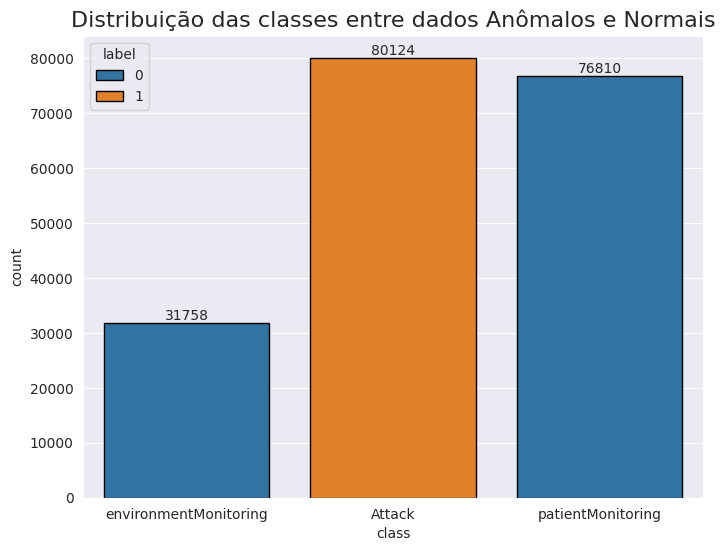

In [ ]:
sns.set_style("darkgrid")
ax = sns.countplot(
    data=df,
    x='class',
    hue='label',
    edgecolor='black')

ax.set_title('Distribuição das classes entre dados Anômalos e Normais',
         fontdict={'fontsize':16})

for container in ax.containers:
  ax.bar_label(container)

In [177]:
df_label_count = df.groupby('label').size().reset_index(name='count')
df_label_count.columns = ['label', 'count']

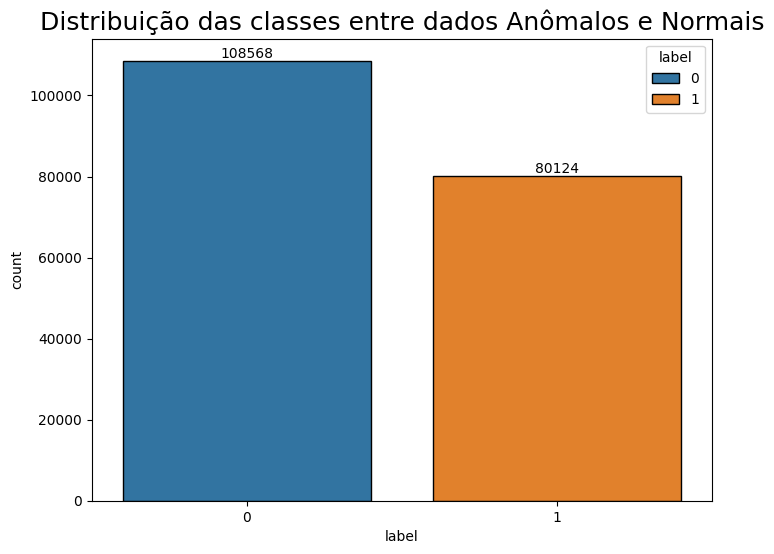

In [ ]:
ax = sns.barplot(
    data = df_label_count,
    x= 'label',
    y= 'count',
    hue= 'label',
    edgecolor='black')

ax.set_title('Distribuição das classes entre dados Anômalos e Normais',
          fontdict={'fontsize':18})

for container in ax.containers:
   ax.bar_label(container)

In [178]:
count_val0 = df_label_count[df_label_count['label'] == 0]['count'].iloc[0]
count_val1 = df_label_count[df_label_count['label'] == 1]['count'].iloc[0]

print(f'Proporção de Classes:\n')
print(f'Instâncias normais: {count_val0/len(df)*100:.2f}%')
print(f'Instâncias anômalas: {count_val1/len(df)*100:.2f}%')

Proporção de Classes:

Instâncias normais: 57.54%
Instâncias anômalas: 42.46%


Indicação de Controle de Fluxo:

O uso da feature mqtt.hdrflags é comum porque essa informação específica pode ser crucial para detectar comportamentos anômalos e atividades maliciosas no tráfego IoT, especialmente no contexto de protocolos como o MQTT

O campo mqtt.hdrflags contém bits de controle importantes, como o tipo de mensagem e configurações de QoS (Quality of Service). Em um ambiente seguro e legítimo, espera-se que certos padrões sejam seguidos nesses campos de controle.
Qualquer discrepância ou configuração incomum nos bits de controle pode indicar uma tentativa de ataque, como spoofing ou negação de serviço.
Detecção de Ataques de Integração e Autenticidade:

Em um ambiente de saúde IoT, ataques de replay ou spoofing podem comprometer a integridade dos dados dos dispositivos médicos.
Alterações ou padrões incomuns nos bits de mqtt.hdrflags podem ser indicadores de que as mensagens foram modificadas ou não são autênticas, o que é um sinal de intrusão.
Identificação de Padrões de QoS:

MQTT usa diferentes níveis de QoS para garantir a entrega de mensagens. Em sistemas de IoT para saúde, um nível específico de QoS é normalmente adotado para certos dispositivos ou aplicações.
Se mqtt.hdrflags indicar níveis de QoS diferentes dos esperados, pode ser um sinal de que algo está fora do normal, potencialmente indicando um comportamento malicioso.
Simplicidade e Frequência do Tráfego MQTT:

Em ambientes IoT, o tráfego MQTT é mais frequente do que o HTTP ou HTTPS, tornando o monitoramento de mqtt.hdrflags eficiente para capturar eventos relevantes em tempo real.
Como mqtt.hdrflags é uma das primeiras informações nos pacotes MQTT, ele oferece uma pista inicial rápida para detectar possíveis ameaças antes de uma análise mais detalhada.

In [179]:
label_encoder = preprocessing.LabelEncoder()
df['mqtt.hdrflags']= label_encoder.fit_transform(df['mqtt.hdrflags'])

In [152]:
category = ['ip.src', 'tcp.srcport', 'tcp.dstport', 'ip.dst', 'tcp.flags', 'tcp.payload', 'tcp.checksum',
            'mqtt.clientid', 'mqtt.conack.flags', 'mqtt.conflags', 'mqtt.msg', 'mqtt.topic', 'class']

In [180]:
df.drop(labels = category, axis=1, inplace=True)

In [154]:
len(df.columns)

30

In [181]:
print(df.dtypes)

frame.time_delta         float64
frame.time_relative      float64
frame.len                  int64
tcp.time_delta           float64
tcp.len                    int64
tcp.ack                    int64
tcp.connection.fin       float64
tcp.connection.rst       float64
tcp.connection.sack      float64
tcp.connection.syn       float64
tcp.flags.ack              int64
tcp.flags.fin              int64
tcp.flags.push             int64
tcp.flags.reset            int64
tcp.flags.syn              int64
tcp.hdr_len                int64
tcp.pdu.size             float64
tcp.window_size_value      int64
mqtt.clientid_len        float64
mqtt.dupflag             float64
mqtt.hdrflags              int64
mqtt.kalive              float64
mqtt.len                 float64
mqtt.msgtype             float64
mqtt.qos                 float64
mqtt.retain              float64
mqtt.topic_len           float64
mqtt.ver                 float64
ip.ttl                     int64
label                      int64
dtype: obj

In [235]:
df_corr = df

In [236]:
corr_matrix = df_corr.corr()

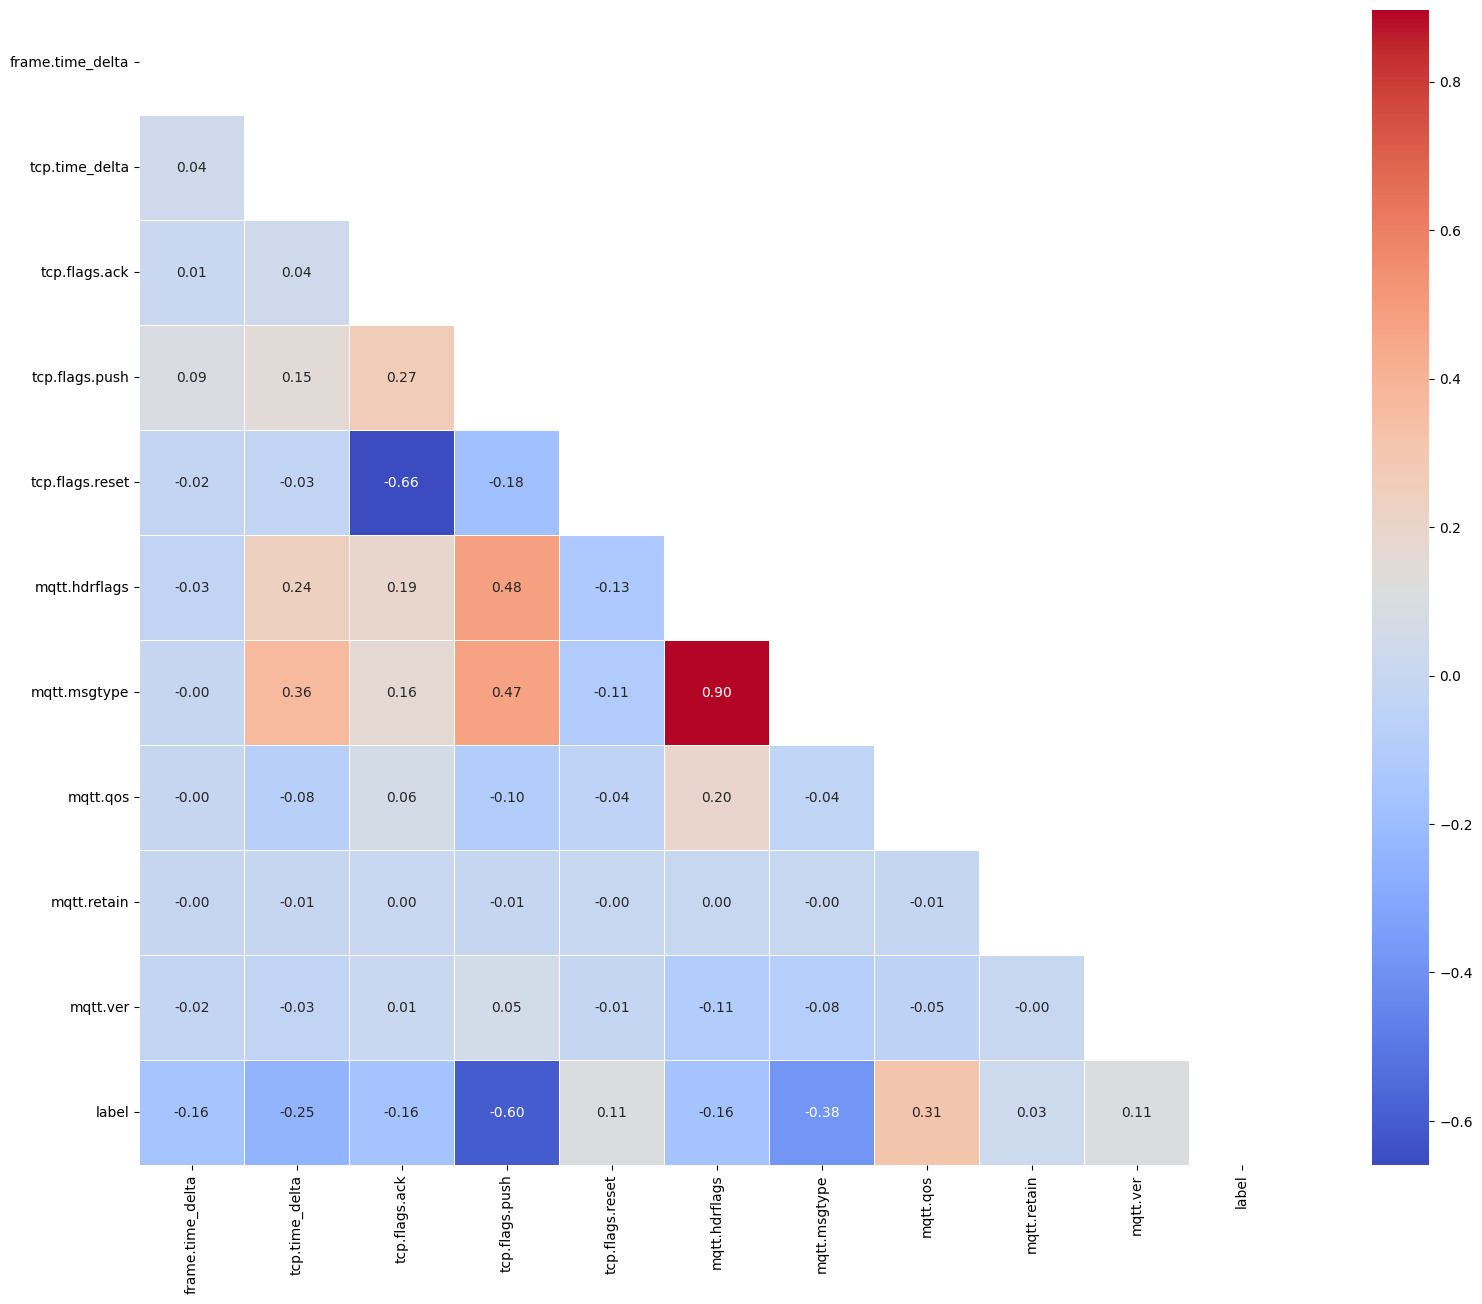

In [237]:
plt.figure(figsize=(20, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,
            annot=True,
            mask=mask,
            linewidth=.5,
            fmt="0.2f",
            cmap='coolwarm',
            square=True)
plt.show()

In [47]:
# Filtrar valores menores que 0.5 e maiores que -0.5
filtered_corr = corr_matrix[(corr_matrix < 0.5) & (corr_matrix > -0.5)]
filtered_corr

,frame.time_delta,frame.time_relative,frame.len,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,...,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,ip.ttl,label
frame.time_delta,NaN,0.084561,-0.050260,0.038235,-0.052725,-0.056634,-0.018219,-0.017944,-0.019690,0.007793,...,-0.031341,-0.014283,-0.064337,-0.003120,-0.003258,-0.004804,-0.066396,-0.019741,-0.070654,-0.155114
frame.time_relative,0.084561,NaN,-0.193739,0.176959,-0.203208,-0.214635,-0.062699,-0.062223,-0.073101,-0.073101,...,0.049803,-0.055995,-0.252745,0.247235,-0.281589,-0.016964,-0.218143,-0.074170,-0.283767,NaN
frame.len,-0.050260,-0.193739,NaN,-0.076980,NaN,-0.062829,-0.028981,-0.031460,-0.029304,-0.027549,...,0.128448,-0.021454,NaN,-0.015736,NaN,0.036201,NaN,-0.024804,-0.102461,0.303510
tcp.time_delta,0.038235,0.176959,-0.076980,NaN,-0.080647,-0.084730,-0.027084,-0.026945,-0.029396,-0.029414,...,0.239444,-0.021243,-0.108177,0.362708,-0.080778,-0.007272,-0.102146,-0.029654,-0.111458,-0.245813
tcp.len,-0.052725,-0.203208,NaN,-0.080647,NaN,-0.055255,-0.027055,-0.028669,-0.031281,-0.031281,...,0.127630,-0.021941,NaN,-0.020438,NaN,0.036607,NaN,-0.023989,-0.093214,0.318520
tcp.ack,-0.056634,-0.214635,-0.062829,-0.084730,-0.055255,NaN,-0.027191,-0.027531,-0.030039,-0.030040,...,0.251215,-0.021699,-0.113787,0.051405,-0.113055,-0.007429,-0.137532,-0.030289,NaN,0.338443
tcp.connection.fin,-0.018219,-0.062699,-0.028981,-0.027084,-0.027055,-0.027191,NaN,-0.008778,-0.009578,-0.009578,...,-0.085150,-0.006919,-0.037894,-0.065103,-0.042936,-0.002370,-0.039761,-0.009658,0.102007,0.109364
tcp.connection.rst,-0.017944,-0.062223,-0.031460,-0.026945,-0.028669,-0.027531,-0.008778,NaN,-0.009525,-0.009525,...,-0.128270,-0.006881,-0.046656,-0.111240,-0.042699,-0.002357,-0.051403,-0.009604,-0.036273,0.108761
tcp.connection.sack,-0.019690,-0.073101,-0.029304,-0.029396,-0.031281,-0.030039,-0.009578,-0.009525,NaN,-0.010394,...,-0.139960,-0.007508,-0.050908,-0.121377,-0.046591,-0.002572,-0.056087,-0.010480,0.103184,0.118673
tcp.connection.syn,0.007793,-0.073101,-0.027549,-0.029414,-0.031281,-0.030040,-0.009578,-0.009525,-0.010394,NaN,...,-0.139960,-0.007508,-0.050908,-0.121377,-0.046591,-0.002572,-0.056087,-0.010480,-0.039579,0.118673


In [182]:
best_features = ['frame.time_delta', 'tcp.time_delta', 'tcp.flags.ack', 'tcp.flags.push', 'tcp.flags.reset', 'mqtt.hdrflags', 'mqtt.msgtype', 'mqtt.qos', 'mqtt.retain', 'mqtt.ver', 'label']

[’frame.time_delta’, ’tcp.time_delta’, ’tcp.flags.ack’, ’tcp.flags.push’, ’tcp.flags.reset’,
’mqtt.hdrflags’, ’mqtt.msgtype’, ’mqtt.qos’, ’mqtt.retain’, ’mqtt.ver’]

In [184]:
df = df[best_features]

In [189]:
feats = df.select_dtypes(include=['float64', 'int64']).columns
unique_vals(df, feats)

Colunas: frame.time_delta
------------------------------
Valores Unicos: 11904

Value Counts: frame.time_delta
0.000001    14271
0.000000    12088
0.000003     2735
0.000025     2599
0.000024     2567
            ...  
6.886630        1
0.052399        1
0.051140        1
0.043011        1
0.004245        1
Name: count, Length: 11904, dtype: int64

Colunas: tcp.time_delta
------------------------------
Valores Unicos: 49228

Value Counts: tcp.time_delta
0.000000    12516
0.000001    12479
0.000003     2028
0.000002     1738
0.000004     1006
            ...  
0.021934        1
0.019050        1
0.013789        1
0.008958        1
1.989338        1
Name: count, Length: 49228, dtype: int64

Colunas: tcp.flags.ack
------------------------------
Valores Unicos: 2

Value Counts: tcp.flags.ack
1    185159
0      3533
Name: count, dtype: int64

Colunas: tcp.flags.push
------------------------------
Valores Unicos: 2

Value Counts: tcp.flags.push
1    148950
0     39742
Name: count, dtype: int

# Verificação e ratificação de atributos com baixa correlação para o modelo

<Figure size 1200x1000 with 0 Axes>

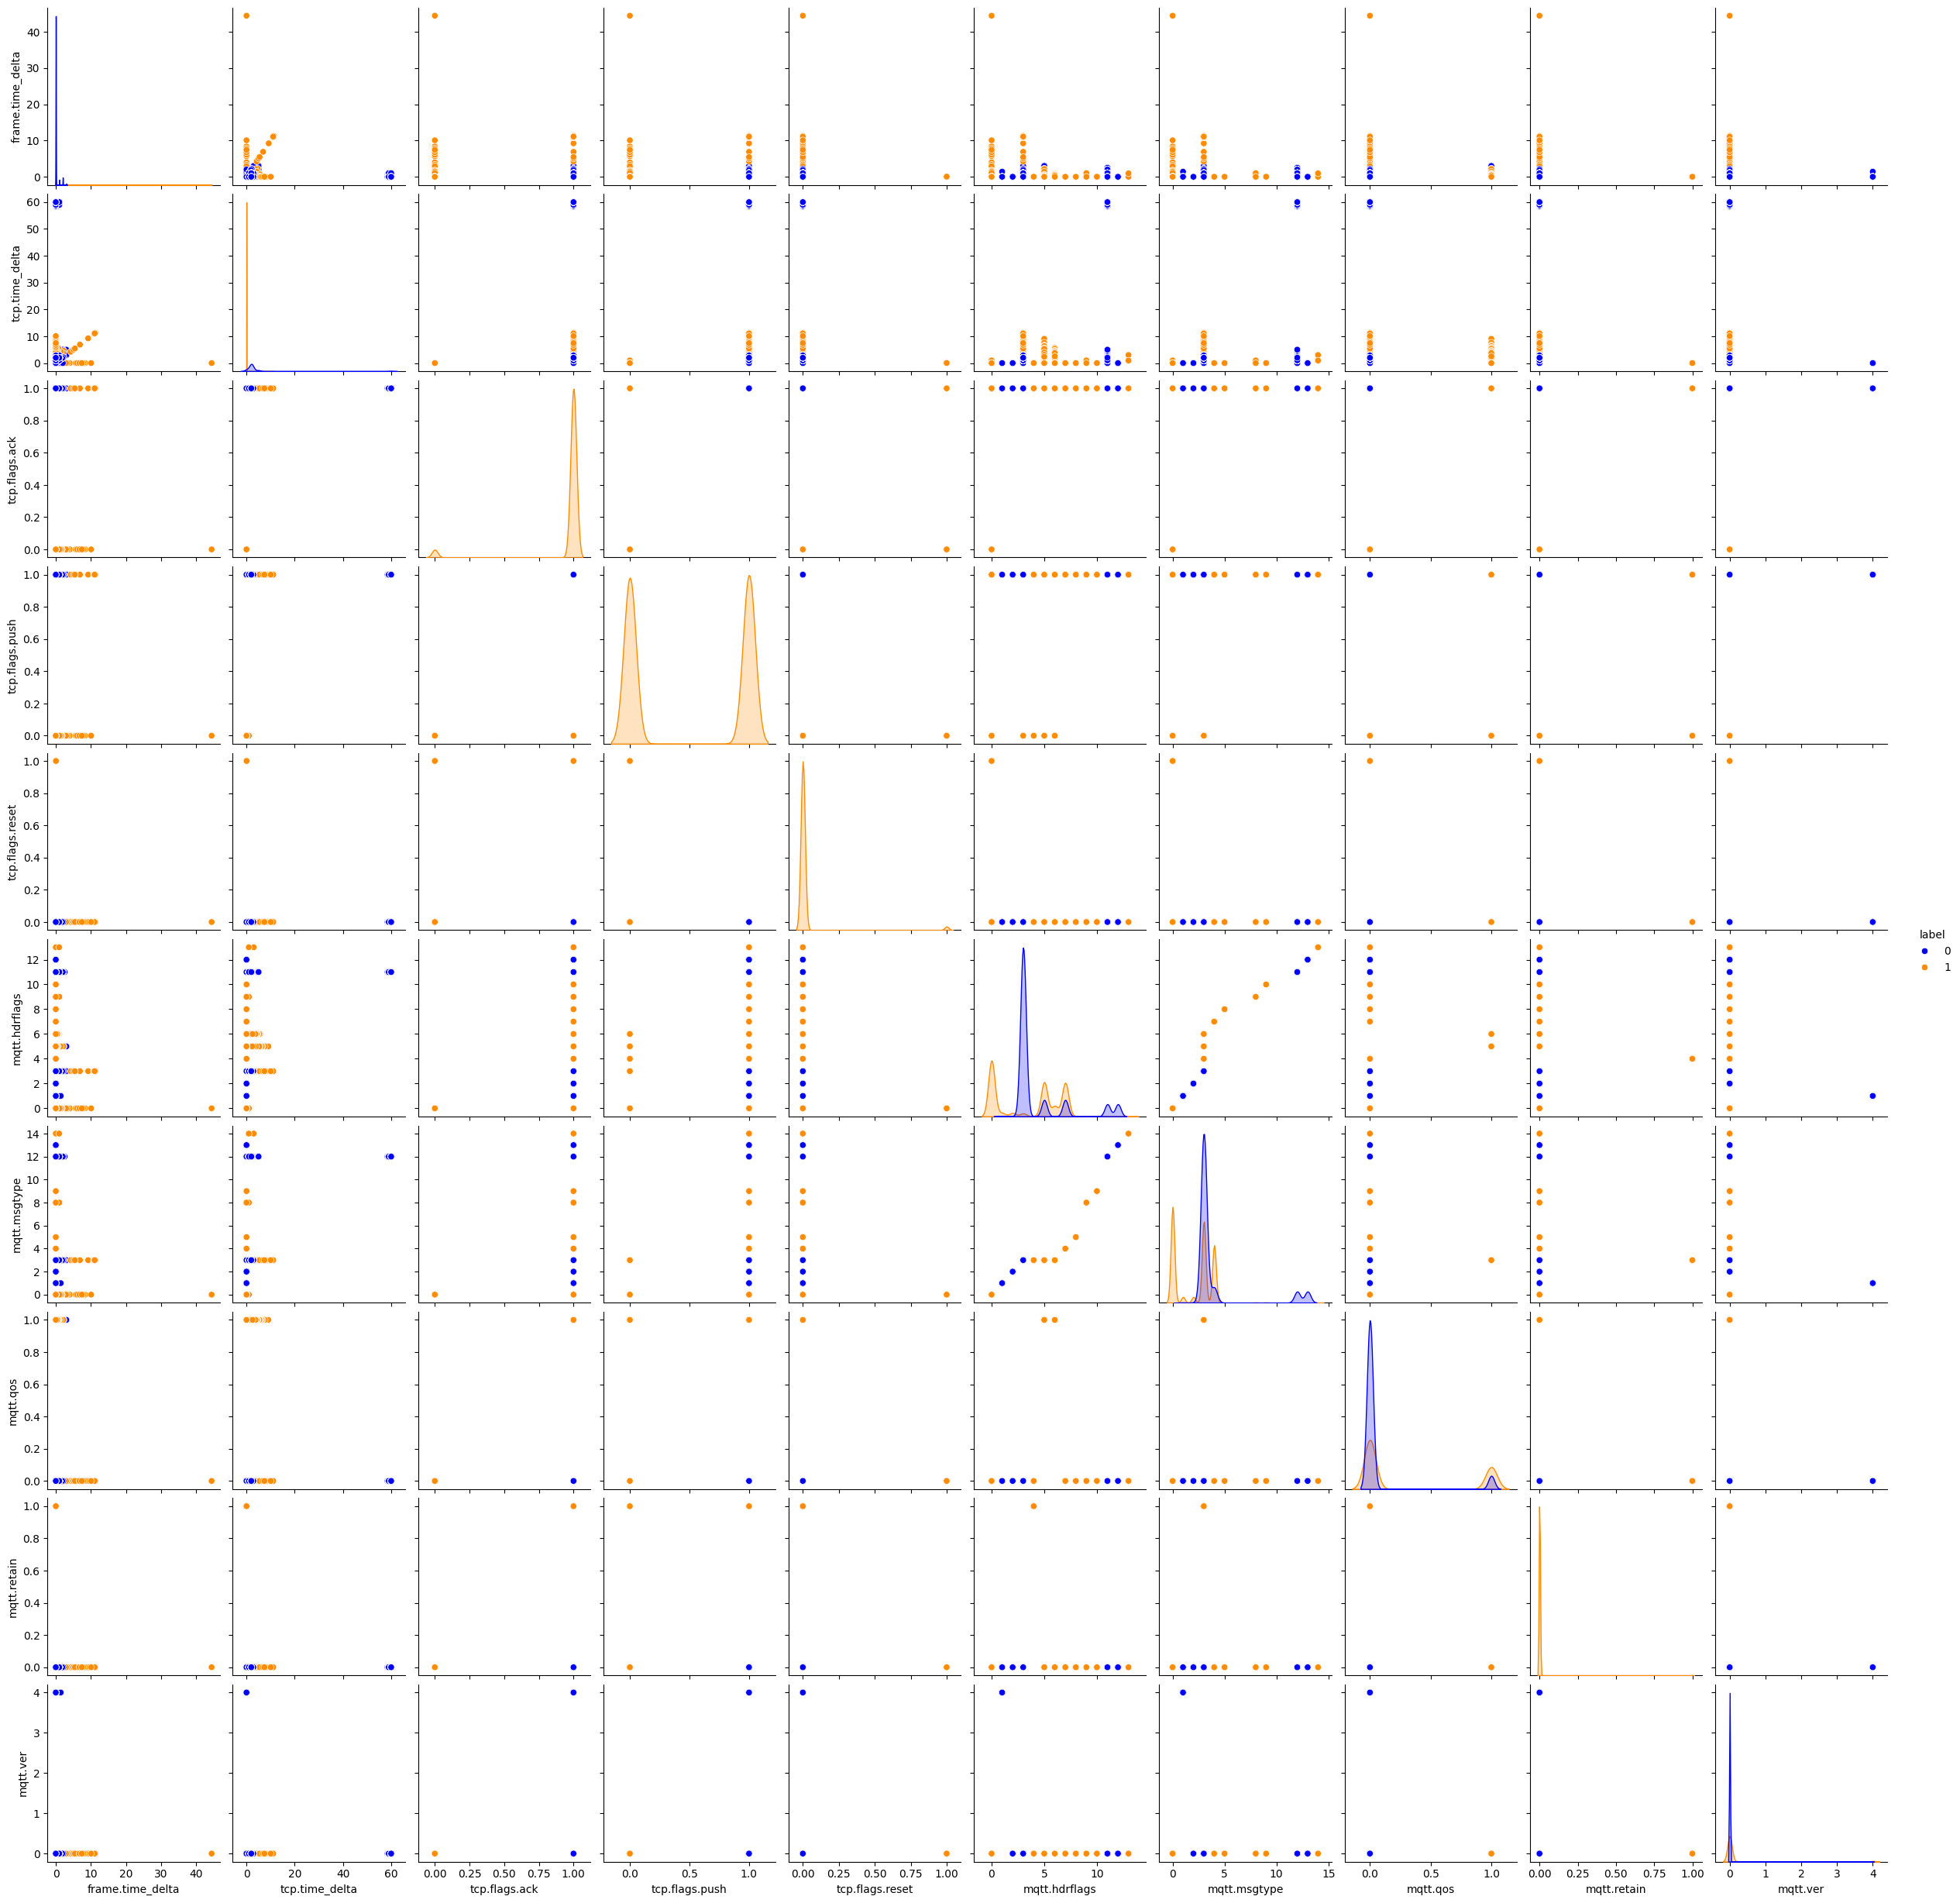

In [238]:
plt.figure(figsize=(12,10))
sns.pairplot(
    df,
    diag_kind="kde",
    hue='label',
    palette = ["blue","darkorange"]
)
plt.show()

# Divisão dos dados em Variáveis Dependentes e Independentes

In [190]:
#Preparando variáveis dependentes
y = df['label']
y.shape

(188692,)

In [191]:
#Preparando variáveis independentes
X = df.drop('label', axis = 1)
X.shape

(188692, 10)

#Etapa de Normalização


In [ ]:
# scale = StandardScaler()

In [192]:
scale = MinMaxScaler()

In [193]:
scale.fit(X)
X_scaled = scale.transform(X)

In [194]:
X_scale_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scale_df

,frame.time_delta,tcp.time_delta,tcp.flags.ack,tcp.flags.push,tcp.flags.reset,mqtt.hdrflags,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.ver
0,0.000000e+00,0.000000e+00,1.0,1.0,0.0,0.076923,0.071429,0.0,0.0,1.0
1,1.192718e-06,8.827841e-07,1.0,1.0,0.0,0.153846,0.142857,0.0,0.0,0.0
2,9.676770e-07,0.000000e+00,1.0,1.0,0.0,0.076923,0.071429,0.0,0.0,1.0
3,4.500823e-07,3.331261e-07,1.0,1.0,0.0,0.153846,0.142857,0.0,0.0,0.0
4,3.600659e-07,0.000000e+00,1.0,1.0,0.0,0.076923,0.071429,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
188687,4.410807e-06,3.313535e-02,1.0,1.0,0.0,0.230769,0.214286,0.0,0.0,0.0
188688,3.870708e-06,3.313502e-02,1.0,1.0,0.0,0.230769,0.214286,0.0,0.0,0.0
188689,2.835519e-06,3.313500e-02,1.0,1.0,0.0,0.230769,0.214286,0.0,0.0,0.0
188690,3.285601e-06,3.313290e-02,1.0,1.0,0.0,0.230769,0.214286,0.0,0.0,0.0


#Divisão dos dados em Treinamento e Teste

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_scale_df,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=42)

In [196]:
print('Tamanho de cada uma das amostras:')
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train:  {y_train.shape}')
print(f'y_test: {y_test.shape}')

Tamanho de cada uma das amostras:
X_train: (132084, 10)
X_test:  (56608, 10)
y_train:  (132084,)
y_test: (56608,)


#Parte 1

# Aplicação do Algoritmo de Regressão Logística

In [197]:
model = LogisticRegression()

# Definição de Parâmetros para o GridSearchCV alinhado ao StratifiedCrossVal

In [198]:
param_grid_l1 = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1'],
    'model__solver': ['liblinear']  # solver for L1 penalty
}

param_grid_l2 = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']  # solver for L2 penalty
}

param_grid_elasticnet = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['elasticnet'],
    'model__l1_ratio': [0.1, 0.5, 0.9],
    'model__solver': ['saga']
}

In [199]:
# Combinar todas os grids
param_grid = [param_grid_l1, param_grid_l2, param_grid_elasticnet]
param_grid

[{'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'model__penalty': ['l1'],
  'model__solver': ['liblinear']},
 {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'model__penalty': ['l2'],
  'model__solver': ['lbfgs']},
 {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
  'model__penalty': ['elasticnet'],
  'model__l1_ratio': [0.1, 0.5, 0.9],
  'model__solver': ['saga']}]

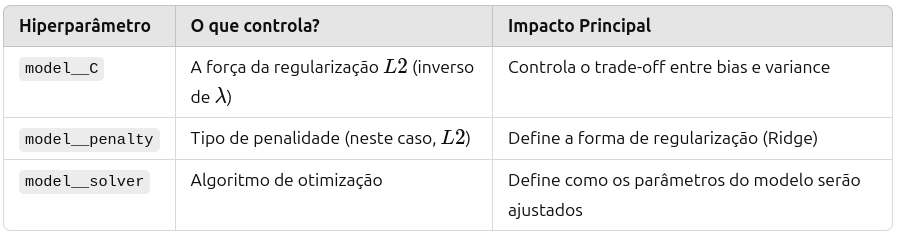

# StratifiedCrossCV

In [200]:
# Configurando o StratifiedKFold para validação cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

# Utilização da Técnica de Oversampling (SMOTE) alinhado ao StratifiedKFold com 5 splits

In [201]:
# Configurando o StratifiedKFold para validação cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)
smote = SMOTE(random_state=42)

lst_accu_stratified = []

# Stratified k-fold cross-validation com SMOTE
for train_index, test_index in stratified_kfold.split(X_scale_df, y):
    x_train_fold, x_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Aplica SMOTE no conjunto de treinamento
    X_resampled, y_resampled = smote.fit_resample(x_train_fold, y_train_fold)

    # Treina o modelo com os dados aumentados
    model.fit(X_resampled, y_resampled)

    # Calcula a acurácia no conjunto de teste do fold
    accuracy = model.score(x_test_fold, y_test_fold)
    lst_accu_stratified.append(accuracy)

# Lista de acurácias para cada fold
print("Acurácia de cada fold:", lst_accu_stratified)

Acurácia de cada fold: [0.9440522751120862, 0.9435108192759591, 0.9447350430068207]


#Model Pipelining

In [202]:
# Define o pipeline com SMOTE e o modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=100))
])

# GridSearchCV

In [203]:
grid_search = GridSearchCV(
    estimator = pipeline,   # O estimador a ser otimizado
    param_grid = param_grid,# O conjunto de parâmetros para a busca
    cv = stratified_kfold,  #A validação cruzada estratificada
    scoring = 'accuracy',   #A métrica para avaliar a performance
    n_jobs = -1,            #Uso de múltiplos núcleos
    verbose = 1             #Detalhamento das informações durante o processo
)

# 30 min para execução

In [204]:
# Ajustando o GridSearchCV aos dados de treinamento
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__penalty': ['l1'],
                          'model__solver': ['liblinear']},
                         {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__penalty': ['l2'],
                          'model__solver': ['lbfgs']},
                         {'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'model__l1_ratio': [0.1, 0.5, 0.9],
                          'model__penalty': ['elasticnet'],
                          'model__solver': ['saga']}],
             scoring='accuracy', verbose=1)

# Melhores parâmetros encontrados com GridSearchCV

In [205]:
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

Melhores parâmetros encontrados:
{'model__C': 1, 'model__l1_ratio': 0.9, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}


Melhores parâmetros encontrados:
{'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

In [206]:
# Melhor modelo ajustado
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=1, l1_ratio=0.9, penalty='elasticnet',
                                    solver='saga'))])

In [207]:
# Fazendo previsões com o melhor modelo
y_pred = best_model.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 1, 1])

# Matriz de Confusão para Novos Dados (Matriz anterior ao Oversampling)

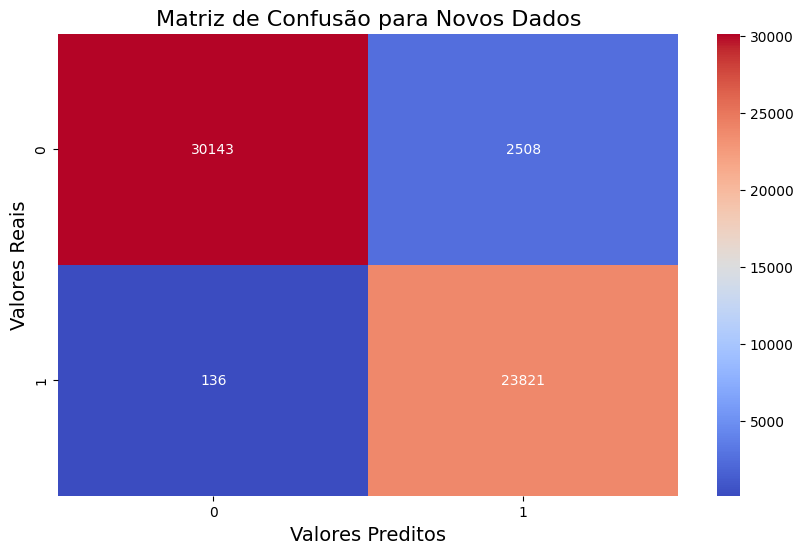

In [208]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
plt.title('Matriz de Confusão para Novos Dados', fontsize=16)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Reais', fontsize=14)
plt.show()

In [209]:
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Metricas:")
print(f'Acuracia: {acuracia*100:.2f}%')
print(f'Precisao: {precisao*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'f1-score: {f1*100:.2f}%')

Metricas:
Acuracia: 95.33%
Precisao: 90.47%
Recall: 99.43%
f1-score: 94.74%


#Calculo da curva ROC e AUC

In [210]:
best_model = LogisticRegression(max_iter=10000)
best_model.fit(X_train, y_train)
y_probs = best_model.predict_proba(X_test)[:, 1]

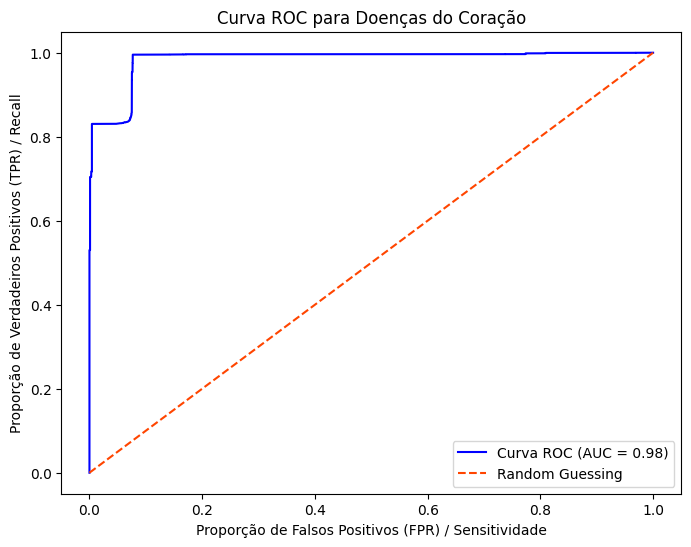

In [211]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plotar a ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='orangered')
plt.xlabel('Proporção de Falsos Positivos (FPR) / Sensitividade')
plt.ylabel('Proporção de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC para Doenças do Coração')
plt.legend()
plt.show()

# Parte 2

# Aplicação do Random Forest
- https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings

In [212]:
rf_model = RandomForestClassifier(random_state=42)

- https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
- n_estimators = number of trees in the foreset (By default: n_estimators=100). n_estimator is the hyperparameter that defines the number of trees to be used in the model.
- max_features = max number of features considered for splitting a node. Max_features limits a count to select the maximum features in each tree.(By default: max_features="sqrt" [available: ["sqrt", "log2", None}])
- max_depth = max number of levels in each decision tree. max_depth determines the maximum number of splits each tree can take. If the max_depth is too low, the model will be trained less and have a high bias, leading the model to underfit. In the same way, if the max_depth is high, the model learns too much and leads to high variance, leading the model to overfit. (By default: max_depth=None)


- min_samples_split = a parameter that tells the decision tree in a random forest the minimum required number of observations in any given node in order to split it.The default value of the minimum_sample_split is assigned to 2
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

A. Hyperparameters of a Random Forest include:
1. Number of Trees: The quantity of decision trees in the forest.
2. Tree Depth: Maximum depth of each decision tree.
3. Number of Features: The count of features considered at each split.
4. Criterion: Measure to evaluate quality of splits (e.g., Gini impurity, entropy).
5. Minimum Samples per Leaf: Minimum samples required in a leaf node.
6. Minimum Samples per Split: Minimum samples required to split a node.
7. Bootstrap Sampling: Whether to use bootstrap sampling while building trees.

In [80]:
pprint(rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


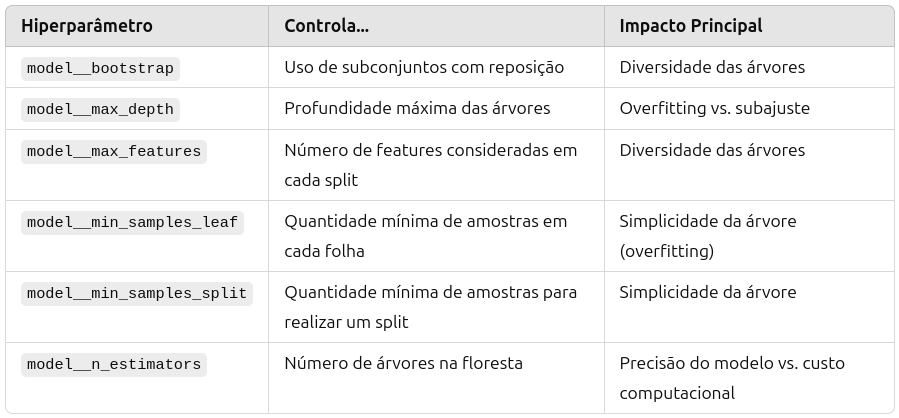

# Definição dos Parâmetros para o Modelo

In [213]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 3)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(5, 15, num = 5)]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]

# Random Grid

In [214]:
random_grid = {
    'model__n_estimators': n_estimators,
    'model__max_features': max_features,
    'model__max_depth': max_depth,
    'model__min_samples_split': min_samples_split,
    'model__min_samples_leaf': min_samples_leaf,
    'model__bootstrap': bootstrap
}

In [215]:
pprint(random_grid )

{'model__bootstrap': [True, False],
 'model__max_depth': [5, 7, 10, 12, 15],
 'model__max_features': ['sqrt', 'log2'],
 'model__min_samples_leaf': [1, 2, 3],
 'model__min_samples_split': [2, 3, 4],
 'model__n_estimators': [100, 250, 400]}


# Treinamento com Random Search utilizando o StratifiedKFold
- Os argumentos mais importantes no RandomizedSearchCV são n_iter, que controla o número de diferentes combinações a serem testadas, e cv stratified_kfold com , que é o número de folds a serem usados para validação cruzada. Mais iterações cobrirão um espaço de busca mais amplo e mais dobras de validação cruzada reduzem as chances de overfitting, mas aumentar cada um deles aumentará o tempo de execução.

In [223]:
# Configurando o StratifiedKFold para validação cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

#Verificação da acurácia entre folds

In [217]:
# Stratified k-fold cross-validation com SMOTE
lst_accu_stratified = []
stratified_kfold = StratifiedKFold(n_splits=5)
smote = SMOTE(random_state=42)

for train_index, test_index in stratified_kfold.split(X_scale_df, y):
    x_train_fold, x_test_fold = X_scale_df.iloc[train_index], X_scale_df.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Aplica SMOTE no conjunto de treinamento
    X_resampled, y_resampled = smote.fit_resample(x_train_fold, y_train_fold)

    # Treina o modelo com os dados aumentados
    rf_model.fit(X_resampled, y_resampled)

    # Calcula a acurácia no conjunto de teste do fold
    accuracy = rf_model.score(x_test_fold, y_test_fold)
    lst_accu_stratified.append(accuracy)

# Lista de acurácias para cada fold
print("Acurácia de cada fold:", lst_accu_stratified)


Acurácia de cada fold: [0.8203450011924004, 0.9319006862926945, 0.9971911601038741, 1.0, 0.9502093380677301]


In [224]:
# Define o pipeline com SMOTE e o modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

# RandomizedSearchCV com stratified_kfold

In [225]:
rf_random = RandomizedSearchCV(estimator = pipeline,
                               param_distributions = random_grid,
                               n_iter = 30,
                               cv = stratified_kfold,
                               verbose = 2,
                               random_state = 42,
                               n_jobs = -1)

# Tempo: 50m23s

In [226]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [5, 7, 10, 12, 15],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2, 3],
                                        'model__min_samples_split': [2, 3, 4],
                                        'model__n_estimators': [100, 250, 400]},
                   random_state=42, verbose=2)

In [227]:
print("Melhores parâmetros encontrados:")
pprint(rf_random.best_params_)


Melhores parâmetros encontrados:
{'model__bootstrap': False,
 'model__max_depth': 15,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 3,
 'model__n_estimators': 250}


Melhores parâmetros encontrados:
{'model__bootstrap': True,
 'model__max_depth': 15,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 400}

In [228]:
# Melhor modelo ajustado
best_model = rf_random.best_estimator_
best_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(bootstrap=False, max_depth=15,
                                        max_features='log2', min_samples_leaf=2,
                                        min_samples_split=3, n_estimators=250,
                                        random_state=42))])

In [229]:
# Fazendo previsões com o melhor modelo
y_pred = best_model.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 1, 1])

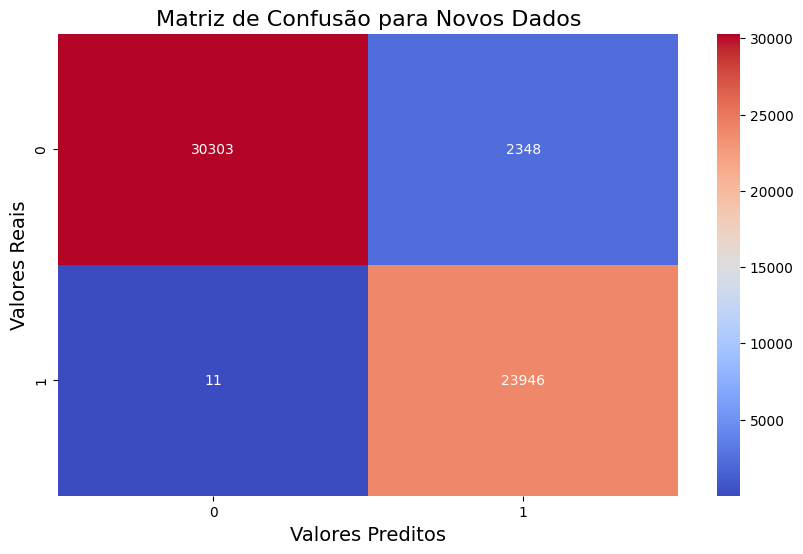

In [230]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
plt.title('Matriz de Confusão para Novos Dados', fontsize=16)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Reais', fontsize=14)
plt.show()

In [231]:
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Metricas:")
print(f'Acuracia: {acuracia*100:.2f}%')
print(f'Precisao: {precisao*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'f1-score: {f1*100:.2f}%')

Metricas:
Acuracia: 95.83%
Precisao: 91.07%
Recall: 99.95%
f1-score: 95.31%


In [232]:
y_probs = best_model.predict_proba(X_test)[:, 1]

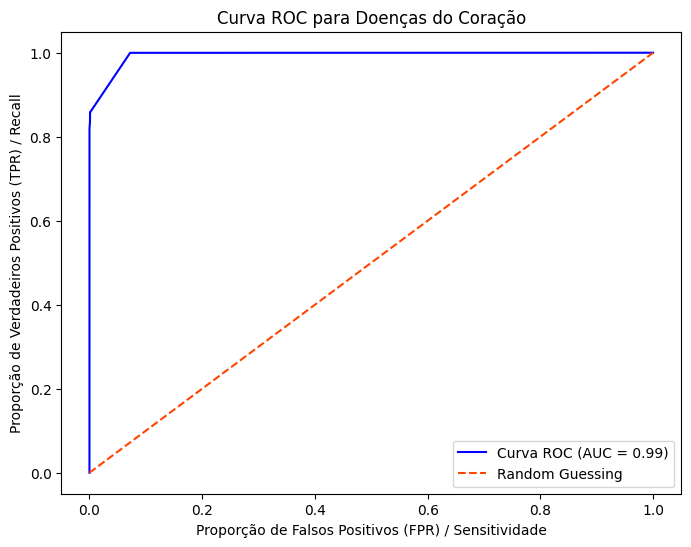

In [233]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plotar a ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='orangered')
plt.xlabel('Proporção de Falsos Positivos (FPR) / Sensitividade')
plt.ylabel('Proporção de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC para Doenças do Coração')
plt.legend()
plt.show()

# Árvore de Decisão (Teste)

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [239]:
dt_model = DecisionTreeClassifier()

In [240]:
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
criterion = ['gini', 'entropy']

In [241]:
random_grid = {
    'model__max_depth': max_depth,
    'model__min_samples_split': min_samples_split,
    'model__criterion': criterion
}

In [242]:
# Define o pipeline com SMOTE e o modelo
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', DecisionTreeClassifier(random_state=42))
])

In [243]:
# Configurando o StratifiedKFold para validação cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=42)

In [244]:
grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = random_grid,
                           cv = stratified_kfold,
                           scoring='accuracy')

In [245]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 5, 10],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [246]:
print("Melhores parâmetros encontrados:")
pprint(grid_search.best_params_)

Melhores parâmetros encontrados:
{'model__criterion': 'gini',
 'model__max_depth': 10,
 'model__min_samples_split': 2}


In [247]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [248]:
# Fazendo previsões com o melhor modelo
y_pred = best_model.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 1, 1])

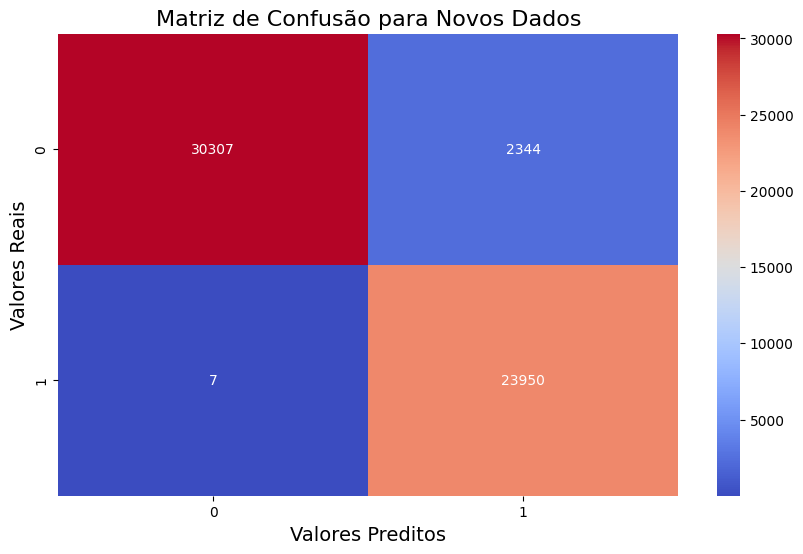

In [249]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
plt.title('Matriz de Confusão para Novos Dados', fontsize=16)
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Valores Preditos', fontsize=14)
plt.ylabel('Valores Reais', fontsize=14)
plt.show()

In [250]:
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Metricas:")
print(f'Acuracia: {acuracia*100:.2f}%')
print(f'Precisao: {precisao*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'f1-score: {f1*100:.2f}%')

Metricas:
Acuracia: 95.85%
Precisao: 91.09%
Recall: 99.97%
f1-score: 95.32%


In [251]:
y_probs = best_model.predict_proba(X_test)[:, 1]

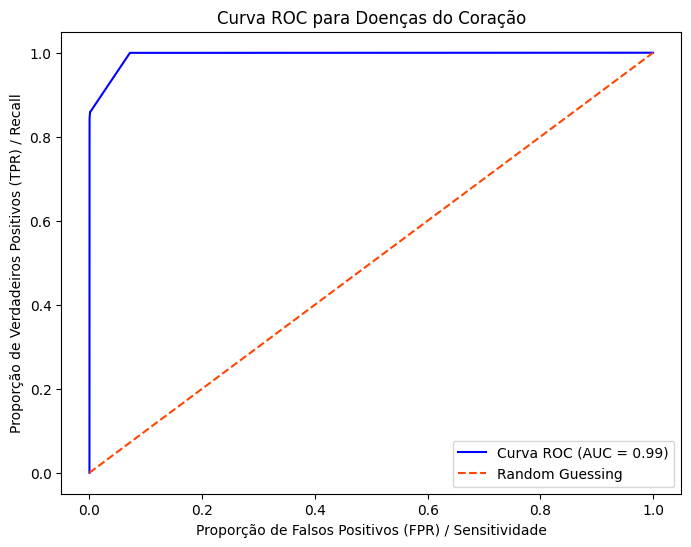

In [252]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plotar a ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='orangered')
plt.xlabel('Proporção de Falsos Positivos (FPR) / Sensitividade')
plt.ylabel('Proporção de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC para Doenças do Coração')
plt.legend()
plt.show()